In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pymc as pm
import arviz as az

# Set random seed for reproducibility
np.random.seed(42)

# Number of observations
n = 1000

# Simulate running variable (X)
X = np.random.uniform(-1, 1, n)

# Define the cutoff
cutoff = 0

# Simulate treatment assignment with fuzziness (probability increases around cutoff)
def treatment_assignment(x):
    prob = 0.2 + 0.6 * (x > cutoff)  # 20% probability below cutoff, 80% above
    return np.random.binomial(1, prob)

D = np.array([treatment_assignment(x) for x in X])

# Simulate the true treatment effect and outcome (Y)
true_effect = 2
noise = np.random.normal(0, 1, n)

# Outcome variable: Y = f(X) + true_effect * D + noise
Y = 3 * X + true_effect * D + noise

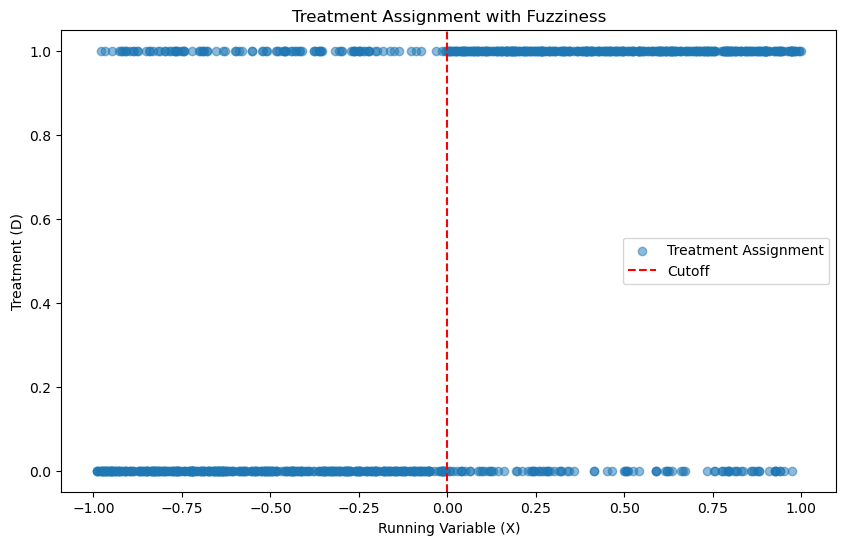

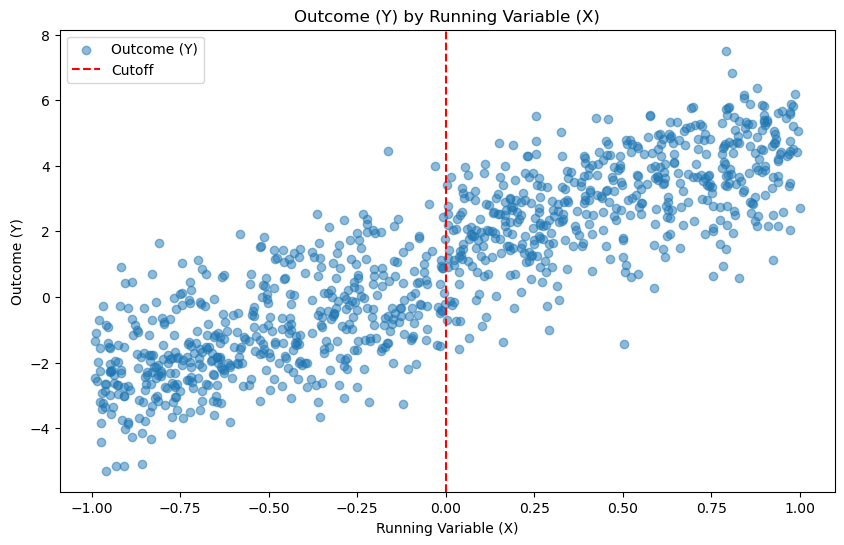

In [6]:
# Visualization of treatment assignment
plt.figure(figsize=(10, 6))
plt.scatter(X, D, alpha=0.5, label="Treatment Assignment")
plt.axvline(cutoff, color="red", linestyle="--", label="Cutoff")
plt.title("Treatment Assignment with Fuzziness")
plt.xlabel("Running Variable (X)")
plt.ylabel("Treatment (D)")
plt.legend()
plt.show()

# Visualization of outcome (Y)
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, alpha=0.5, label="Outcome (Y)")
plt.axvline(cutoff, color="red", linestyle="--", label="Cutoff")
plt.title("Outcome (Y) by Running Variable (X)")
plt.xlabel("Running Variable (X)")
plt.ylabel("Outcome (Y)")
plt.legend()
plt.show()

In [3]:
X_design = sm.add_constant(np.column_stack((X, (X > cutoff).astype(int))))

In [17]:
with pm.Model() as model:
    # Priors for first stage
    first_stage_betas = pm.Normal("first_stage", mu=0, sigma=10, shape=X_design.shape[1])

    # Likelihood for treatment assignment (first stage)
    D_mean = pm.math.dot(X_design, first_stage_betas)
    sigma_D = pm.HalfNormal("sigma_D", sigma=1)
    D_hat = pm.Normal("D_hat", mu=D_mean, sigma=sigma_D, observed=D)

    # Likelihood for the (second stage)
    second_stage_betas = pm.Normal("second_stage", mu=0, sigma=10, shape=X_design.shape[1])
    sigma_Y = pm.HalfNormal("sigma_Y", sigma=1)

    # Likelihood for outcome (second stage)
    Y_mean = pm.math.dot(sm.add_constant(X), second_stage_betas[:X_design.shape[1]-1]) + D_hat * second_stage_betas[X_design.shape[1]-1]
    Y = pm.Normal("Y_hat", mu=Y_mean, sigma=sigma_Y, observed=Y)

In [18]:
with model:
  idata =  pm.sample(nuts_sampler="nutpie")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2000,0,0.58,7
,2000,0,0.63,7
,2000,0,0.59,7
,2000,0,0.59,7


The main focus here is that simulated parameter values are captured by the model.

In [19]:
az.summary(idata, var_names="second_stage")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
second_stage[0],-0.012,0.051,-0.106,0.084,0.001,0.001,2483.0,2618.0,1.0
second_stage[1],2.963,0.062,2.840,3.072,0.001,0.001,3231.0,3169.0,1.0
second_stage[2],2.047,0.075,1.902,2.182,0.002,0.001,2377.0,2438.0,1.0
